# 03 – Weighted two-hub optimisation for the Northern region

In this notebook we use the Northern synthetic dataset, enriched with
the importance score `w_importance`, to identify two strategic hub
locations for the region.

The workflow is:

1. Load the Northern dataset with importance weights.
2. Run a **weighted K-Means** with multiple initialisations and select
   the configuration that gives a good trade-off between:
   - low weighted travel distance, and
   - balanced total importance between the two hubs.
3. Interpret the two cluster centres as candidate hubs.
4. Compute great-circle (Haversine) distances from each customer to both
   hubs and assign each customer to the nearest one.
5. (Optional, external) Show how road distances can be obtained using
   the OpenRouteService API and stored for later visualisation.
6. Export the enriched dataset and the hub table for later use.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)

ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"

# Northern dataset with importance weights (from Notebook 2)
PATH_NORTH_WEIGHTS = DATA_DIR / "customers_synthetic_north_with_weights.csv"
PATH_NORTH_WEIGHTS

WindowsPath('../data/customers_synthetic_north_with_weights.csv')

In [2]:
df = pd.read_csv(PATH_NORTH_WEIGHTS)
df.shape

(63720, 25)

In [3]:
df.head()

,DSREG,CDCLIE,NROPUESUM,VVENTASPROM,LATTUD,LNGTUD,HUB,PESO POR SERVICIOS,CANTIDADEQ,EDADDIAS,Cantserviciosdistri,CantserviciosST,Cantidad total serv,TIEMPO DE EJECUCION PROMEDIO (MINUTOS),TIEMPO PROMEDIO DE LLAMADOS (DIAS),DEPARTAMENTO,DEPARTAMENTO OPTIMO,ZONA OPTIMA,Distancia_punto1_m,Distancia_punto2_m,Cantidad_total_serv,sales_norm,equip_norm,services_norm,w_importance
0,NORTE,6.156346e+06,2,23.817759,-8.150649,-79.841065,TRUJILLO,0,1,2522.513428,0,0,1,0.000000,0.379474,LA LIBERTAD,0.975740,NaN,13571,240357,0,0.036471,0.0,0.0,0.014588
1,NORTE,6.050903e+06,1,47.631922,-9.152026,-78.772544,TRUJILLO,1,1,3169.428633,1,0,1,0.000000,0.857509,ANCASH,0.976667,NaN,14264,0,1,0.086140,0.0,0.2,0.094456
2,NORTE,1.866376e+06,2,21.764656,-9.470377,-78.523142,TRUJILLO,0,1,799.794277,1,0,1,1569.841855,0.301505,ANCASH,0.003087,NaN,2964,283391,1,0.032189,0.0,0.2,0.072876
3,NORTE,1.680596e+06,1,37.902756,-9.159700,-80.276835,TRUJILLO,1,1,1299.107842,2,0,1,124.375773,0.000000,CAJAMARCA,0.007660,NaN,113977,444422,2,0.065848,0.0,0.4,0.146339
4,NORTE,7.936723e+06,1,52.424385,-6.774554,-80.288595,TRUJILLO,2,1,2903.683917,2,1,0,0.000000,0.264073,LA LIBERTAD,0.000000,NaN,194098,340663,3,0.096135,0.0,0.6,0.218454


In [12]:
required_cols = [
    "DSREG",
    "CDCLIE",
    "LATTUD",
    "LNGTUD",
    "VVENTASPROM",
    "CANTIDADEQ",
    "Cantidad_total_serv",
    "w_importance",
]

missing = [c for c in required_cols if c not in df.columns]
missing

[]

In [6]:
df_north = df[df["DSREG"] == "NORTE"].copy()
df_north.shape

(63720, 25)

In [7]:
df_north["DSREG"].value_counts()

DSREG
NORTE    63720
Name: count, dtype: int64

In [13]:
# Coordinates matrix (latitude, longitude)
X_coords = df_north[["LATTUD", "LNGTUD"]].to_numpy()

# Importance weights
weights = df_north["w_importance"].to_numpy()

X_coords[:3], weights[:3]

(array([[ -8.15064874, -79.84106517],
        [ -9.1520264 , -78.77254409],
        [ -9.47037722, -78.52314222]]),
 array([0.01458845, 0.09445588, 0.07287561]))

In [10]:
# Definimos el modelo de K-Means con 2 clusters
# random_state para que el resultado sea reproducible
kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10,
)

# Ajustamos el modelo usando sample_weight
kmeans.fit(X_coords, sample_weight=weights)

# Centros de los clusters (latitud, longitud)
centers = kmeans.cluster_centers_
centers

array([[ -5.04672649, -79.30854218],
       [ -7.95657127, -79.30960822]])

In [11]:
# Creamos un DataFrame con los hubs
df_hubs = pd.DataFrame(
    centers,
    columns=["LATTUD", "LNGTUD"],
)

# Les ponemos nombres simples: Hub_1, Hub_2
df_hubs["HUB_ID"] = ["HUB_1", "HUB_2"]

df_hubs

,LATTUD,LNGTUD,HUB_ID
0,-5.046726,-79.308542,HUB_1
1,-7.956571,-79.309608,HUB_2


### Upgrade: multi–start K-Means with selection metric

Instead of keeping the result from a single K-Means run, we run the algorithm
multiple times with different random seeds and then select the best
configuration based on two criteria:

1. **Weighted average distance**  
   (customers should stay as close as possible to their assigned hub).

2. **Balance of total importance between hubs**  
   (we avoid solutions where almost all importance falls into one hub).

We compute hub imbalance as:

**imbalance = |W1 − W2| / (W1 + W2)**

where:
- **W1** = total importance assigned to hub 1  
- **W2** = total importance assigned to hub 2  

Interpretation:
- **imbalance = 0** → both hubs carry the same importance  
- **imbalance close to 1** → almost all importance is concentrated in a single hub  

To combine both objectives, we define a simple selection score:

**score = avg_weighted_distance + λ × imbalance**

with a small penalty factor (e.g., **λ = 0.1**).  
The solution with the **lowest score** is chosen as the final two-hub configuration.


In [14]:
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Compute great-circle distance between two points in km.

    Parameters
    ----------
    lat1, lon1 : float or array
    lat2, lon2 : float or array

    Returns
    -------
    distance_km : float or array
    """
    R = 6371.0  # Earth radius in km

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [15]:
def evaluate_two_hub_solution(X, w, centers, labels, lambda_imbalance=0.1):
    """
    Compute quality metrics for a two-hub solution.

    - weighted average distance
    - weight imbalance between hubs
    - combined score = avg_dist + lambda * imbalance
    """
    # Centres
    c0_lat, c0_lon = centers[0]
    c1_lat, c1_lon = centers[1]

    # Distances to each centre
    dist0 = haversine_km(X[:, 0], X[:, 1], c0_lat, c0_lon)
    dist1 = haversine_km(X[:, 0], X[:, 1], c1_lat, c1_lon)

    # Distance to assigned hub
    dist_assigned = np.where(labels == 0, dist0, dist1)

    # Weighted average distance
    avg_weighted_dist = np.average(dist_assigned, weights=w)

    # Total weight per hub
    w0 = w[labels == 0].sum()
    w1 = w[labels == 1].sum()
    total_w = w0 + w1

    # Normalised imbalance (0 = perfectly balanced, 1 = all weight in one hub)
    imbalance = abs(w0 - w1) / total_w if total_w > 0 else 0.0

    score = avg_weighted_dist + lambda_imbalance * imbalance

    return {
        "avg_weighted_dist": avg_weighted_dist,
        "imbalance": imbalance,
        "score": score,
        "w0": w0,
        "w1": w1,
    }

In [16]:
results = []
models = []

n_runs = 15
lambda_imbalance = 0.1

for seed in range(n_runs):
    kmeans = KMeans(
        n_clusters=2,
        random_state=seed,
        n_init=10,
    )
    kmeans.fit(X_coords, sample_weight=weights)

    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    metrics = evaluate_two_hub_solution(
        X_coords, weights, centers, labels, lambda_imbalance=lambda_imbalance
    )
    metrics["seed"] = seed
    results.append(metrics)
    models.append(kmeans)

df_runs = pd.DataFrame(results).sort_values("score").reset_index(drop=True)
df_runs

,avg_weighted_dist,imbalance,score,w0,w1,seed
0,123.916256,0.444239,123.960679,2491.069585,6473.473183,14
1,123.916505,0.444239,123.960929,6473.473183,2491.069585,1
2,123.917109,0.444239,123.961533,6473.473183,2491.069585,5
3,123.917109,0.444239,123.961533,2491.069585,6473.473183,4
4,123.918081,0.444255,123.962506,2490.998638,6473.544130,11
5,123.918081,0.444255,123.962506,6473.544130,2490.998638,13
6,123.918476,0.444255,123.962902,2490.998638,6473.544130,3
7,123.918915,0.444319,123.963347,2490.710841,6473.831927,7
8,123.919374,0.444319,123.963806,6473.831927,2490.710841,9
9,123.919992,0.444338,123.964426,2490.626413,6473.916355,12


In [17]:
best_idx = df_runs["score"].idxmin()
best_row = df_runs.loc[best_idx]
best_row

avg_weighted_dist     123.916256
imbalance               0.444239
score                 123.960679
w0                   2491.069585
w1                   6473.473183
seed                   14.000000
Name: 0, dtype: float64

In [18]:
best_model = models[best_idx]
best_centers = best_model.cluster_centers_
best_labels = best_model.labels_

best_centers

array([[ -7.95535699, -79.30962491],
       [ -5.04357339, -79.30849638]])

In [19]:
df_hubs = pd.DataFrame(
    best_centers,
    columns=["LATTUD", "LNGTUD"],
)

df_hubs["HUB_ID"] = ["HUB_1", "HUB_2"]

df_hubs

,LATTUD,LNGTUD,HUB_ID
0,-7.955357,-79.309625,HUB_1
1,-5.043573,-79.308496,HUB_2


In [20]:
df_north["cluster_id"] = best_labels

cluster_to_name = {0: "HUB_1", 1: "HUB_2"}
df_north["assigned_hub"] = df_north["cluster_id"].map(cluster_to_name)

# Coordinates of hubs
hub1_lat, hub1_lon = df_hubs.loc[df_hubs["HUB_ID"] == "HUB_1", ["LATTUD", "LNGTUD"]].iloc[0]
hub2_lat, hub2_lon = df_hubs.loc[df_hubs["HUB_ID"] == "HUB_2", ["LATTUD", "LNGTUD"]].iloc[0]

df_north["dist_km_hub1"] = haversine_km(df_north["LATTUD"], df_north["LNGTUD"], hub1_lat, hub1_lon)
df_north["dist_km_hub2"] = haversine_km(df_north["LATTUD"], df_north["LNGTUD"], hub2_lat, hub2_lon)

df_north["dist_km_assigned"] = df_north[["dist_km_hub1", "dist_km_hub2"]].min(axis=1)

df_north[["CDCLIE", "assigned_hub", "dist_km_assigned"]].head()

,CDCLIE,assigned_hub,dist_km_assigned
0,6.156346e+06,HUB_1,62.410438
1,6.050903e+06,HUB_1,145.579647
2,1.866376e+06,HUB_1,189.345384
3,1.680596e+06,HUB_1,171.008488
4,7.936723e+06,HUB_1,169.982607


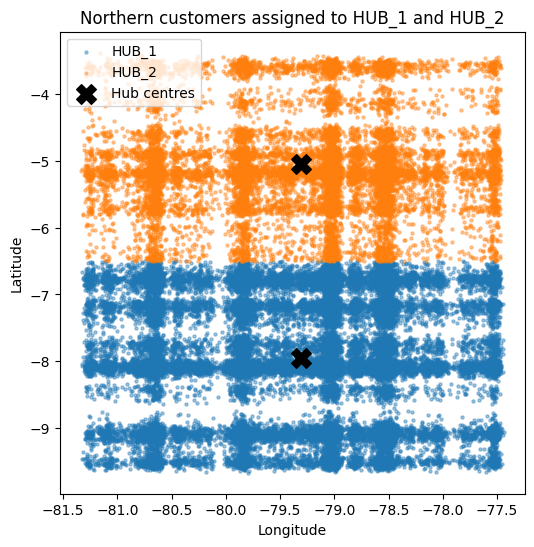

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

for hub_name, group in df_north.groupby("assigned_hub"):
    ax.scatter(
        group["LNGTUD"],
        group["LATTUD"],
        s=5,
        alpha=0.4,
        label=hub_name,
    )

ax.scatter(
    df_hubs["LNGTUD"],
    df_hubs["LATTUD"],
    s=200,
    marker="X",
    c="black",
    label="Hub centres",
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Northern customers assigned to HUB_1 and HUB_2")
ax.legend()
plt.show()

In [22]:
summary_hubs = (
    df_north
    .groupby("assigned_hub")
    .agg(
        customers=("CDCLIE", "count"),
        total_importance=("w_importance", "sum"),
        avg_distance_km=("dist_km_assigned", "mean"),
        max_distance_km=("dist_km_assigned", "max"),
    )
)

summary_hubs

,customers,total_importance,avg_distance_km,max_distance_km
assigned_hub,,,,
HUB_1,46143,6474.582331,128.443252,282.318666
HUB_2,17577,2489.960437,113.729980,276.475583


# Using ORS to calculate the distance between the tentative hubs and each client 

In [24]:
import os
import requests

# API key should be stored in an environment variable for security.
# it's a secret hehe:
#   export ORS_API_KEY="your-key-here, like that"
ORS_API_KEY = os.getenv("ORS_API_KEY")

# Base URL for openrouteservice directions
ORS_DIRECTIONS_URL = "https://api.openrouteservice.org/v2/directions/driving-hgv"

In [25]:
def ors_route_distance_km(lat_from, lon_from, lat_to, lon_to):
    """
    Query OpenRouteService for the road distance between two points.

    This function assumes that the ORS_API_KEY environment variable is set.
    For the project, calls were executed offline and results were stored
    in separate files to avoid hitting the API repeatedly.
    """
    if ORS_API_KEY is None:
        raise RuntimeError("ORS_API_KEY is not set. Please configure your API key.")

    headers = {
        "Authorization": ORS_API_KEY,
        "Content-Type": "application/json",
    }

    payload = {
        "coordinates": [
            [lon_from, lat_from],
            [lon_to, lat_to],
        ],
        # Heavy goods vehicle profile (5-ton truck, simplified) or hgv for simplier purposes
        "extra_info": ["steepness"],
        "units": "km",
    }

    response = requests.post(ORS_DIRECTIONS_URL, json=payload, headers=headers)
    response.raise_for_status()
    data = response.json()

    # Distance in km from ORS summary
    distance_m = data["features"][0]["properties"]["summary"]["distance"]
    distance_km = distance_m / 1000.0

    return distance_km

In practice, these calls were executed offline and the resulting 144 MB dataset of road distances and routes was saved as HTML/CSV for visual inspection and not recomputed inside the notebook, I used ORS in docker in order to get rid of the limit of interactions per day

In [26]:
# Example (commented out completely):
#
# sample_row = df_north.sample(1, random_state=0).iloc[0]
#
# road_km = ors_route_distance_km(
#     lat_from=hub1_lat,
#     lon_from=hub1_lon,
#     lat_to=sample_row["LATTUD"],
#     lon_to=sample_row["LNGTUD"],
# )
#
# road_km


In [27]:
OUTPUT_CUSTOMERS = DATA_DIR / "customers_north_with_hubs.csv"
OUTPUT_HUBS = DATA_DIR / "hubs_north.csv"

df_north.to_csv(OUTPUT_CUSTOMERS, index=False)
df_hubs.to_csv(OUTPUT_HUBS, index=False)

OUTPUT_CUSTOMERS, OUTPUT_HUBS


(WindowsPath('../data/customers_north_with_hubs.csv'),
 WindowsPath('../data/hubs_north.csv'))

## Summary

- A weighted K-Means with multiple initialisations was used to identify
  two hub locations for the Northern region. The final configuration was
  selected by minimising a simple score that combines weighted average
  distance and a penalty for strong imbalance in total importance between
  hubs.

- The chosen hubs (`HUB_1` and `HUB_2`) split the customer base into two
  catchment areas. For each customer we computed Haversine distances to
  both hubs and stored the distance to the assigned hub in
  `dist_km_assigned`.

- In a separate offline step, road distances and routes were obtained
  using the OpenRouteService API with the `driving-hgv` profile
  (5-ton truck). These results were stored in external files and used to
  build interactive HTML maps showing hubs, customers and road paths.

- The tables `customers_north_with_hubs.csv` and `hubs_north.csv`
  will be used in the next notebook to simulate and compare different
  decision policies on top of this two-hub configuration.
